In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

In [222]:
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)

100%|██████████| 50/50 [00:06<00:00,  8.10it/s, epoch=4/4, avg_epoch_loss=0.831]


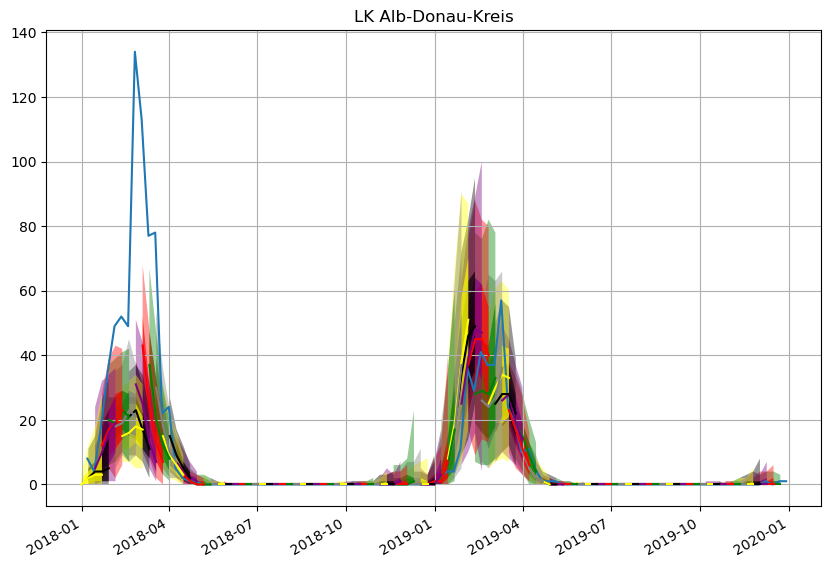

In [4]:
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:1]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"] * windows_per_location
    # Iterate through the correct index by changing the range with [windows_per_location]
    for k in range(0 + windows_per_location*locations.index(location),
                   windows_per_location + windows_per_location*locations.index(location)):
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

## Splitting the Forecasts into their week ahead composition

In [5]:
one_week_ahead_forecasts=[]
for location in locations:
    start_date_list = []
    # define the index of the time wise first forecast point
    first_time_point_of_location = windows_per_location + windows_per_location*locations.index(location)-1
    # save the array corresponding to the first week 
    weekly_samples_array = forecasts[first_time_point_of_location].samples[:,:1]
    # also append the time wise first [start_date] to [start_date_list]
    start_date_list.append(forecasts[first_time_point_of_location].start_date)
    for k in range(first_time_point_of_location - 1,
                   first_time_point_of_location - windows_per_location, -1):
        
        weekly_samples_array = np.concatenate((weekly_samples_array, forecasts[k].samples[:, :1]), axis=1)
        start_date_list.append(forecasts[k].start_date)
    
    one_week_ahead_forecasts.append(gluonts.model.forecast.SampleForecast(
        info=forecasts[first_time_point_of_location].info,
        item_id=forecasts[first_time_point_of_location].item_id,
        samples=weekly_samples_array,
        start_date=min(start_date_list)))

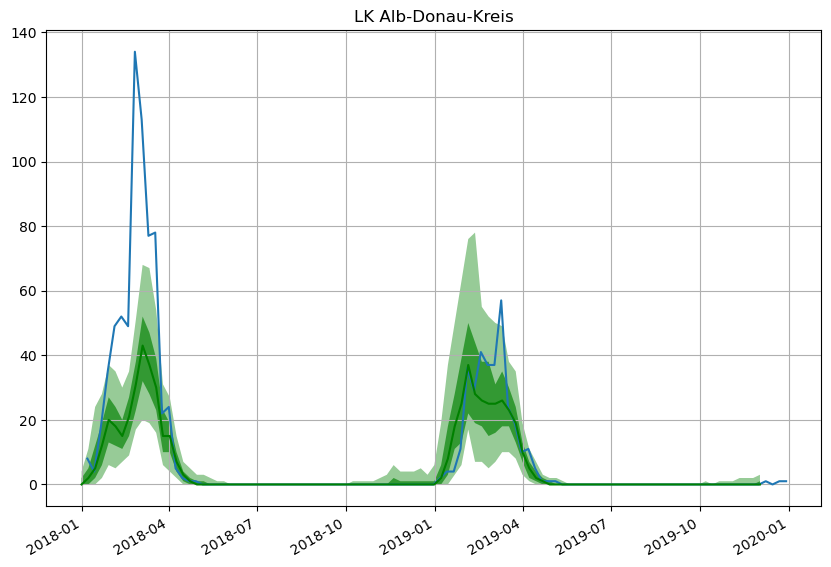

In [6]:
# PLot the Splitted Forecasts for each location
for location in locations[:1]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"]
    forecast_entry = one_week_ahead_forecasts[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

### Use the Implementation within model.py

In [223]:
two_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)
one_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)
three_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)
four_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)

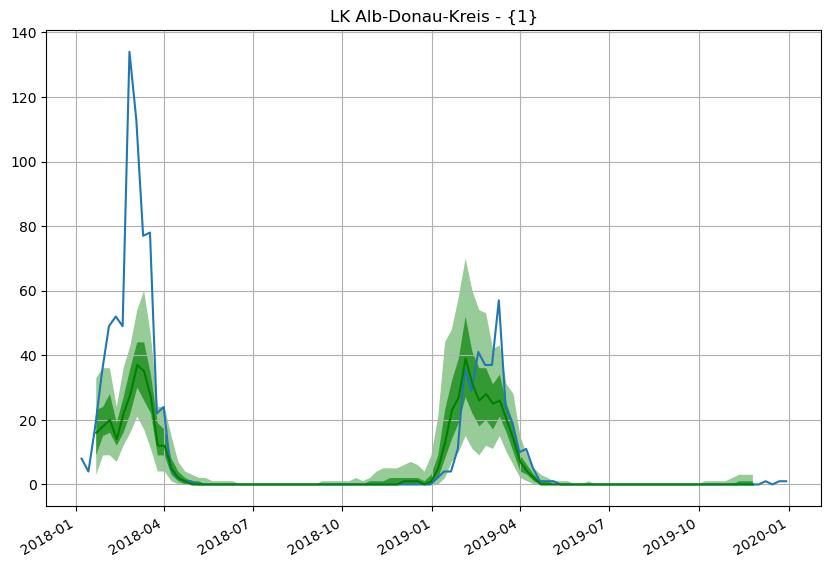

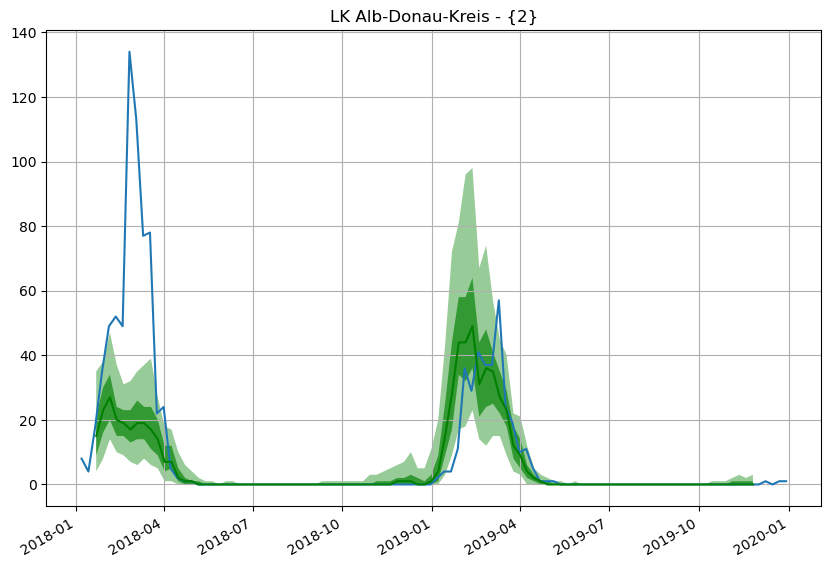

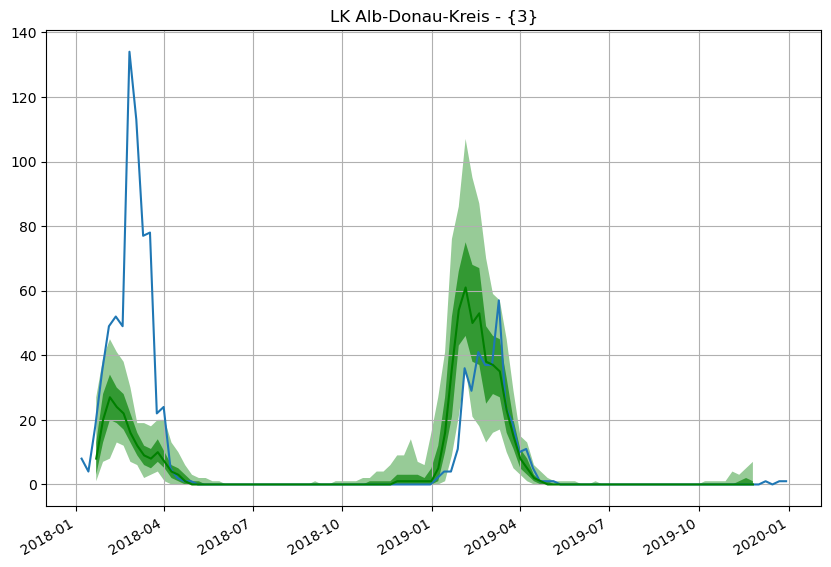

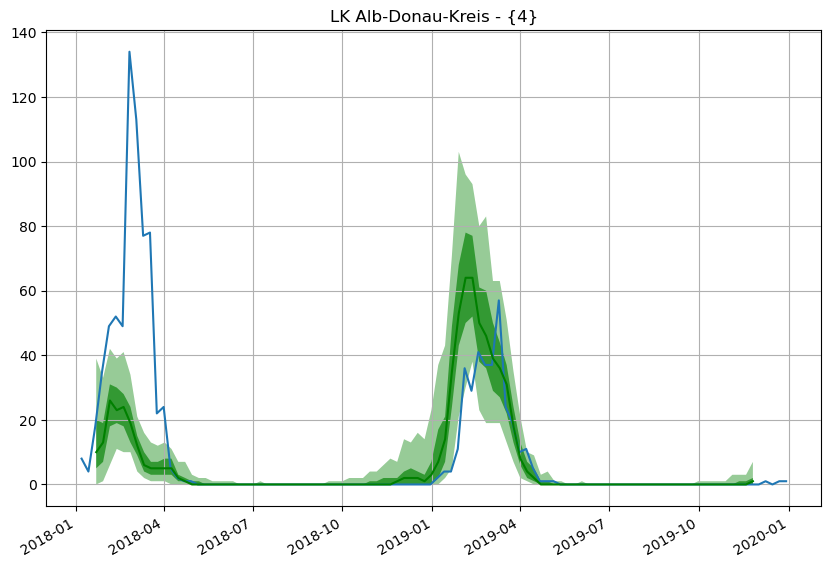

In [224]:
forecast_dict ={1 : one_week_ahead_forecasts,
                2 : two_week_ahead_forecasts,
                3 : three_week_ahead_forecasts,
                4 : four_week_ahead_forecasts}
for location in locations[:1]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

In [225]:
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df2 = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[:]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df2 = pd.concat([evaluator_df2, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df2 = pd.concat([evaluator_df2, pd.DataFrame(agg_metrics,index=[0])])

Running evaluation: 411it [00:01, 247.93it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 250.16it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 245.55it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 251.31it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [175]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    #print(evaluator_df[evaluator_df.item_id.isin([str(location) + " {2}" for location in locations[:10]])][['item_id', 'MSE']+[col for col in evaluator_df.columns if "QuantileLoss" in col]])
    print(evaluator_df.loc[evaluator_df.mean_absolute_QuantileLoss>0,['item_id', 'MSE']+[col for col in evaluator_df.columns if "Coverage" in col]])
    mean_weekly_quantile_loss = evaluator_df.loc[evaluator_df.mean_absolute_QuantileLoss >0,"mean_absolute_QuantileLoss"].mean()
    print(mean_weekly_quantile_loss)
    

          item_id       MSE  Coverage[0.025]  Coverage[0.1]  Coverage[0.25]  \
0  aggregated {1}   544.969            0.006          0.023           0.062   
0  aggregated {2}   971.401            0.007          0.029           0.073   
0  aggregated {3}  1287.875            0.008          0.032           0.081   
0  aggregated {4}  1463.943            0.009          0.036           0.086   

   Coverage[0.5]  Coverage[0.75]  Coverage[0.9]  Coverage[0.975]  MAE_Coverage  
0          0.164           0.323          0.478            0.747         0.243  
0          0.171           0.321          0.468            0.733         0.242  
0          0.182           0.322          0.462            0.723         0.242  
0          0.190           0.322          0.458            0.719         0.240  
219872.92500000002


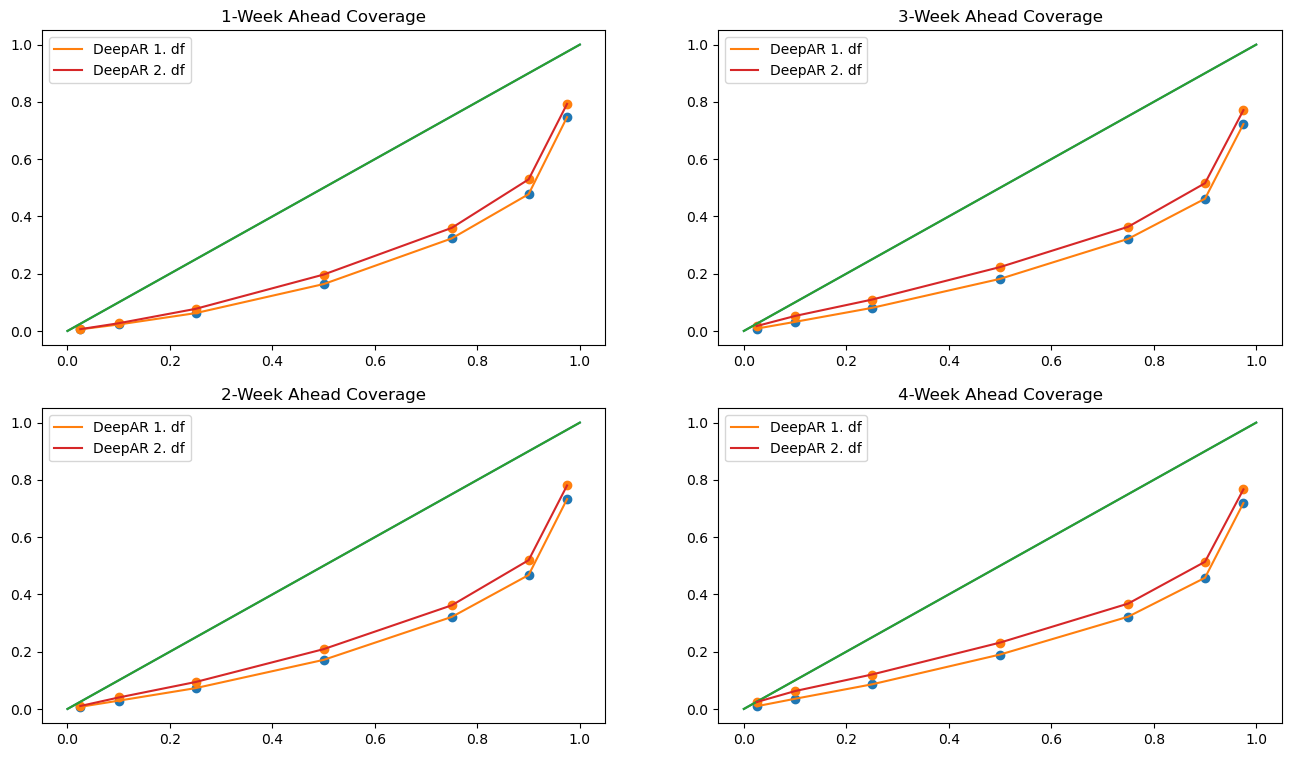

In [234]:
def plot_coverage(evaluator_df_dict):
    week_coverage_dict = {}
    coverage_columns = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "Coverage" in col]
    coverage_columns.remove("MAE_Coverage")
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
    for week in range(1,5):
        if week == 1:
            axse = (0, 0)
        if week == 2:
            axse =(1, 0)
        if week == 3:
            axse = (0, 1)
        if week == 4:
            axse = (1, 1)
        for key in evaluator_df_dict.keys():
            week_coverage_dict[week] = evaluator_df_dict[key].loc[evaluator_df_dict[key].item_id.isin(["aggregated {"+ f"{week}" + "}"]), coverage_columns]
            axs[axse].plot([0.0, 1.0], [0.0, 1.0])
            axs[axse].scatter(config.quantiles, evaluator_df_dict[key].loc[evaluator_df_dict[key].item_id.isin(["aggregated {" + f"{week}" + "}"]), coverage_columns])
            axs[axse].plot(config.quantiles, evaluator_df_dict[key].loc[evaluator_df_dict[key].item_id.isin(["aggregated {" + f"{week}" + "}"]), coverage_columns].T, label=f"{key}. df")
            axs[axse].title.set_text(f"{week}-Week Ahead Coverage")
            axs[axse].legend()
plot_coverage({"DeepAR 1":evaluator_df, "DeepAR 2":evaluator_df2})

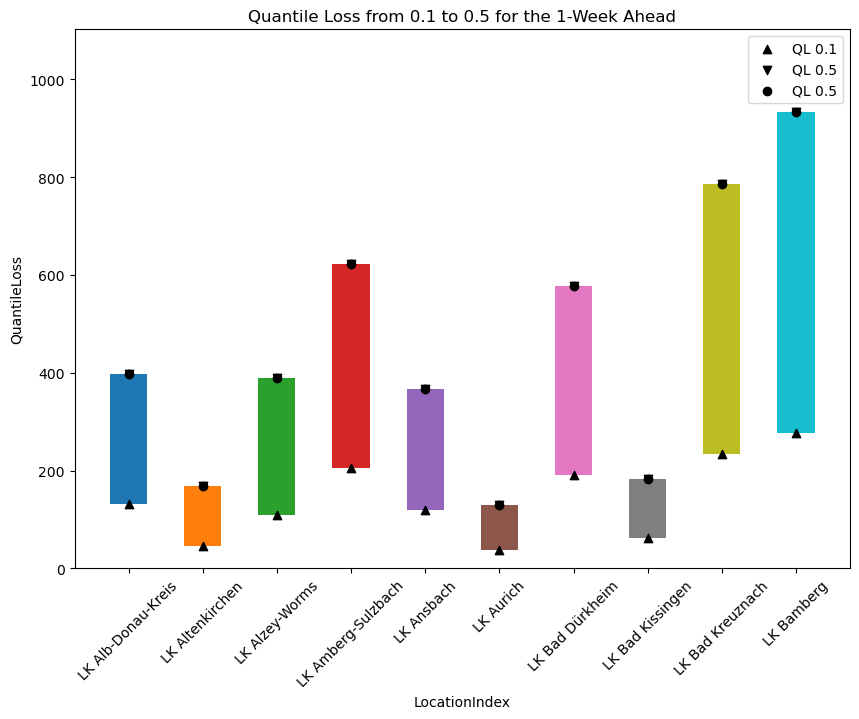

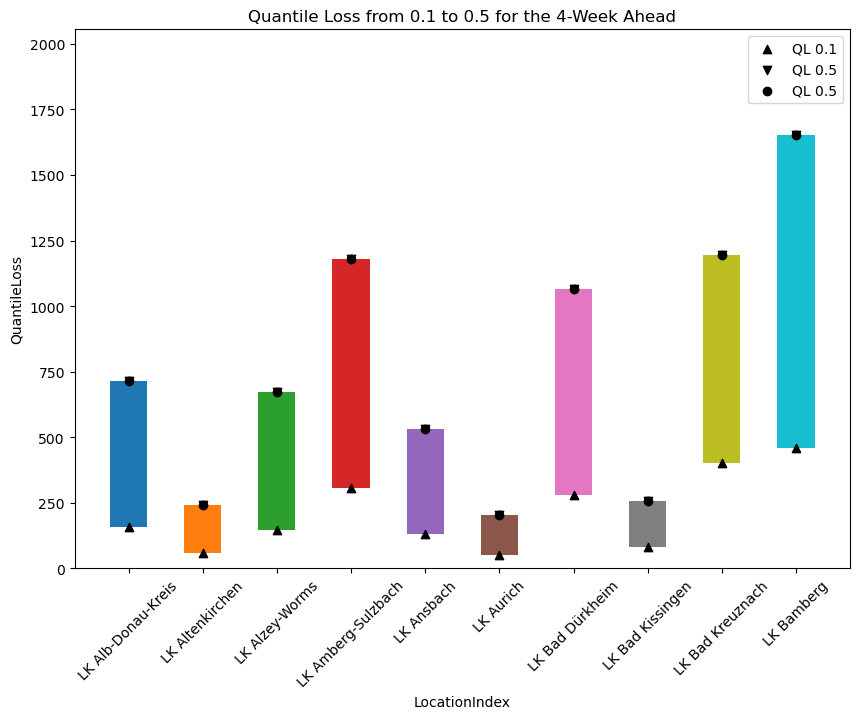

In [168]:
def plot_quantile_loss(evaluator_df, quantiles=[0.1, 0.9], week=1, number_of_locations=10):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    if type(number_of_locations) == int:
        considered_locations = locations[:number_of_locations]
    elif type(number_of_locations) == list:
        considered_locations = number_of_locations
    location_item_id_list = [str(location) + " {" + f"{week}"+"}" for location in considered_locations]
    
    ax.set_ylim(0,max(evaluator_df.loc[evaluator_df.item_id.isin(location_item_id_list),[col for col in evaluator_df.columns if "QuantileLoss" in col]].max())+100)
    ax.set_ylabel("QuantileLoss")
    ax.set_xlabel("LocationIndex")
    for location in considered_locations:
        plt.bar(location, evaluator_df.loc[evaluator_df.item_id.isin([str(location) + " {" + f"{week}"+"}"]),f'QuantileLoss[{quantiles[1]}]'] - \
                evaluator_df.loc[evaluator_df.item_id.isin([str(location) + " {" + f"{week}"+"}"]),f'QuantileLoss[{quantiles[0]}]'],
                0.5,evaluator_df.loc[evaluator_df.item_id.isin([str(location) + " {" + f"{week}"+"}"]),f'QuantileLoss[{quantiles[0]}]'])
    plt.scatter(considered_locations, evaluator_df.loc[evaluator_df.item_id.isin(location_item_id_list),f'QuantileLoss[{quantiles[0]}]'], c="black", marker="^", label=f"QL {quantiles[0]}")
    plt.scatter(considered_locations, evaluator_df.loc[evaluator_df.item_id.isin(location_item_id_list),f'QuantileLoss[{quantiles[1]}]'], c="black", marker="v", label=f"QL {quantiles[1]}")
    plt.scatter(considered_locations, evaluator_df.loc[evaluator_df.item_id.isin(location_item_id_list),'QuantileLoss[0.5]'],c="black", label = "QL 0.5")
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f"Quantile Loss from {quantiles[0]} to {quantiles[1]} for the {week}-Week Ahead")
    plt.show()
plot_quantile_loss(evaluator_df, quantiles=[0.1, 0.5], week=1, number_of_locations=10)
plot_quantile_loss(evaluator_df, quantiles=[0.1, 0.5], week=4, number_of_locations=10)

## Hyperparameter training

In [21]:
from gluonts.mx import Trainer
df_dict = {}
for context_length in [4, 52, 104]:
    for num_layers in [2, 4, 8]:
        for num_cells in [64, 128, 256]:
            for epochs in [2, 4, 8]:                
                config.context_length = context_length
                config.num_layers = num_layers
                config.num_cells = num_cells
                config.trainer = Trainer(epochs=epochs)
                identifier = f"cl {context_length}, nl {num_layers}, nc {num_cells}, ep {epochs}"
                forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
                split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
                forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
                evaluator = Evaluator(quantiles=config.quantiles)
                evaluator_df = pd.DataFrame()
                for forecast in forecast_dict.values():
                    agg_metrics, item_metrics = evaluator(split_tss, forecast)
                    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
                    for location in locations[3:4]:
                        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
                        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
                    agg_metrics["item_id"] = f"aggregated {d}"
                    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
                df_dict[identifier] = evaluator_df

100%|██████████| 50/50 [00:06<00:00,  7.88it/s, epoch=4/4, avg_epoch_loss=0.873]
Running evaluation: 411it [00:01, 231.44it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 227.78it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 232.94it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 236.22it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

In [22]:
evaluator_df=pd.DataFrame()
for key in df_dict.keys():
    agg_df = df_dict[key]
    agg_df['param'] = str(key)
    evaluator_df = pd.concat([evaluator_df, agg_df])
with pd.option_context('display.max_rows', None,'display.max_columns', None, 'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0][['item_id', 'param', 'MSE', 'QuantileLoss[0.025]', 'QuantileLoss[0.1]', 'QuantileLoss[0.5]', 'QuantileLoss[0.9]']])
evaluator_df.to_csv("Evaluation.csv",sep=",")

          item_id                       param       MSE  QuantileLoss[0.025]  \
0  aggregated {1}     cl 4, nl 2, nc 64, ep 2   642.262             21688.50   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 2  1042.687             23160.40   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 2  1403.313             25512.60   
0  aggregated {4}     cl 4, nl 2, nc 64, ep 2  1667.568             27640.35   
0  aggregated {1}     cl 4, nl 2, nc 64, ep 4   762.177             21844.85   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 4  1117.346             23103.75   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 4  1495.873             24340.05   
0  aggregated {4}     cl 4, nl 2, nc 64, ep 4  1720.182             25261.35   
0  aggregated {1}     cl 4, nl 2, nc 64, ep 8   779.663             22334.55   
0  aggregated {2}     cl 4, nl 2, nc 64, ep 8  1147.567             23317.95   
0  aggregated {3}     cl 4, nl 2, nc 64, ep 8  1483.800             24392.55   
0  aggregated {4}     cl 4, nl 2, nc 64,